In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 84.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 93.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 91.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [49]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
transform = torchvision.transforms.Compose([ # basic normalization for cifar nothing too big 
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))   # maps [0,1] → [-1,1]
])

trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform) # downloads the cifar just run this 
loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

In [35]:
class Forward: # Le truc du processus qui se calcule vous embêtez pas avec ça
    def __init__(self, lambda_=0.3):
        self.lmbd = lambda_

    def mean(self, x0, t):
        # x0: [B,1,28,28], t: [B] 
        t = t[:, None, None, None] # Trucs de cast de tenseur à la bonne dimension
        return x0 * torch.exp(-self.lmbd * t)          

    def std(self, t):
        t = t[:, None, None, None]
        std = torch.sqrt(1.0 - torch.exp(-2 * self.lmbd * t))
        return std.clamp(min=1e-3) # On utilise ça pour éviter les blow up numériques quand on divise par ça 

    def diffusion_coeff(self, t):
        return (2 * self.lmbd) ** 0.5 * torch.ones_like(t)


def sample_noisy(x0, t, sde): # Renvoie x_t |x_0 image bruitée
    mean = sde.mean(x0, t)
    std = sde.std(t)
    eps = torch.randn_like(x0)
    return mean + std * eps


def conditional_score(x0, xt, t, sde): # Gradient conditionnel calcul
    mean = sde.mean(x0, t)
    std = sde.std(t)                      # already clamped
    return -(xt - mean) / (std ** 2)      # Gaussian score


In [43]:
x0, _ = next(iter(loader))  # x0 shape: [8,1,28,28]

t = torch.rand(x0.size(0)) # Loi uniforme dans [0,1]
sde = Forward(lambda_=0.3)

# sample noisy images
xt = sample_noisy(x0, t, sde)

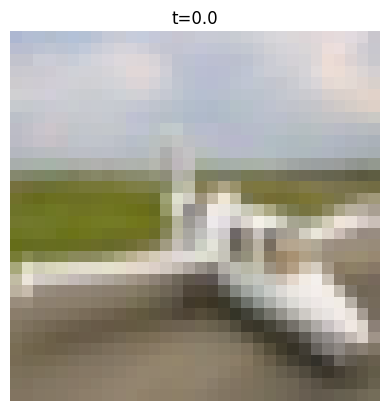

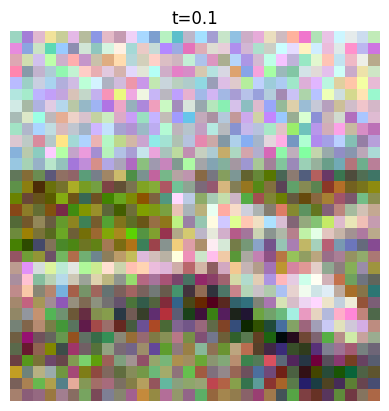

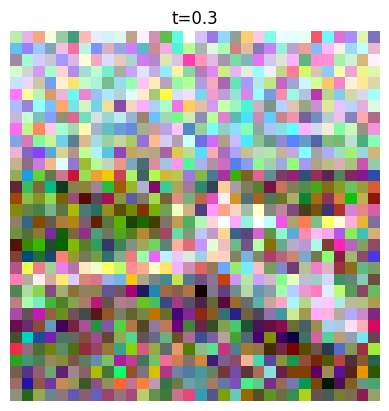

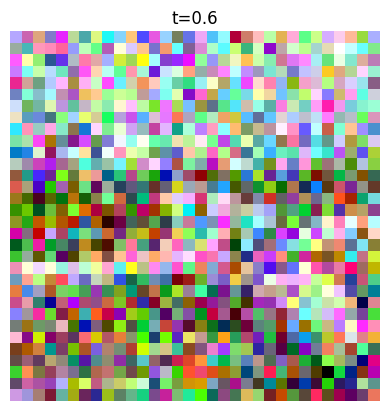

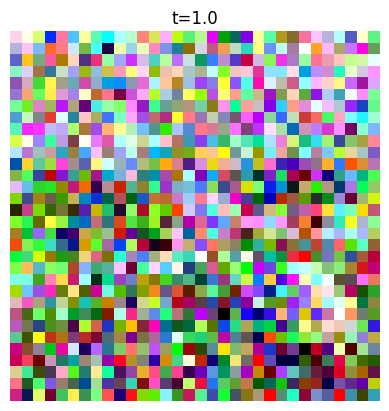

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Vérifiez bien que vous soyez avec support GPU  
@torch.no_grad()
def sample_xt(x0, t, sde):
    mean = sde.mean(x0, t)
    std  = sde.std(t)
    eps  = torch.randn_like(x0)
    return mean + std * eps

x0, _ = next(iter(loader))
x0 = x0.to(device)[:1]

for t_scalar in [0.0, 0.1, 0.3, 0.6, 1.0]:
    t = torch.full((1,), t_scalar, device=device)
    xt = sample_xt(x0, t, sde)
    plt.figure()
    plt.title(f"t={t_scalar}")
    plt.imshow(to_imshow_rgb(xt))
    plt.axis("off")
    plt.show()


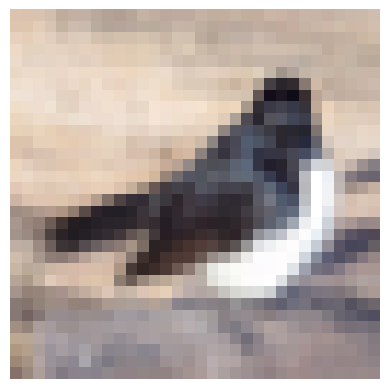

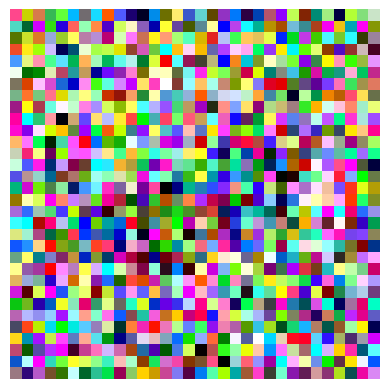

In [32]:
def to_imshow_rgb(x):
    # x: [3,H,W] or [B,3,H,W], float
    if x.dim() == 4:
        x = x[0]
    x = x.detach().cpu()
    x = (x.clamp(-1, 1) + 1) / 2          # -> [0,1]
    x = x.permute(1, 2, 0).numpy()        # CHW -> HWC
    return x

plt.imshow(to_imshow_rgb(x0), interpolation="nearest")
plt.axis("off")
plt.show()

plt.imshow(to_imshow_rgb(xt), interpolation="nearest")
plt.axis("off")
plt.show()


In [45]:
import torch
import torch.nn as nn

class TimeEmbedding(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        self.dim = dim
        self.lin = nn.Linear(dim, dim)

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(
            torch.arange(half_dim, device=t.device) * -(torch.log(torch.tensor(10000.0, device=t.device)) / half_dim)
        )
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return self.lin(emb)  # [B, dim]


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

In [46]:
class UNetScoreCIFAR3Level(nn.Module):
    def __init__(self, time_dim=32, base_channels=128, img_channels=3):
        super().__init__()
        self.time_mlp = TimeEmbedding(dim=time_dim)
        in_ch = img_channels + time_dim  # 3 + time_dim

        C = base_channels

        # -------- Encoder --------
        self.down1 = ConvBlock(in_ch, C)        # 32x32
        self.pool1 = nn.MaxPool2d(2)            # 32->16

        self.down2 = ConvBlock(C, 2*C)          # 16x16
        self.pool2 = nn.MaxPool2d(2)            # 16->8

        self.down3 = ConvBlock(2*C, 4*C)        # 8x8
        self.pool3 = nn.MaxPool2d(2)            # 8->4

        # -------- Bottleneck --------
        self.bottleneck = ConvBlock(4*C, 8*C)   # 4x4

        # -------- Decoder --------
        self.up3 = nn.ConvTranspose2d(8*C, 4*C, kernel_size=2, stride=2)  # 4->8
        self.dec3 = ConvBlock(8*C, 4*C)          # concat(4C + 4C)=8C -> 4C

        self.up2 = nn.ConvTranspose2d(4*C, 2*C, kernel_size=2, stride=2)  # 8->16
        self.dec2 = ConvBlock(4*C, 2*C)          # concat(2C + 2C)=4C -> 2C

        self.up1 = nn.ConvTranspose2d(2*C, C, kernel_size=2, stride=2)    # 16->32
        self.dec1 = ConvBlock(2*C, C)            # concat(C + C)=2C -> C

        # score output has same channels as x: 3
        self.out_conv = nn.Conv2d(C, img_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        # time embedding to spatial map
        emb = self.time_mlp(t)                   # [B, time_dim]
        emb = emb[:, :, None, None]              # [B, time_dim, 1, 1]
        emb = emb.expand(-1, -1, x.size(2), x.size(3))  # [B, time_dim, H, W]

        x_in = torch.cat([x, emb], dim=1)        # [B, 3+time_dim, 32, 32]

        # Encoder
        d1 = self.down1(x_in)                    # [B, C, 32, 32]
        p1 = self.pool1(d1)                      # [B, C, 16, 16]

        d2 = self.down2(p1)                      # [B, 2C, 16, 16]
        p2 = self.pool2(d2)                      # [B, 2C, 8, 8]

        d3 = self.down3(p2)                      # [B, 4C, 8, 8]
        p3 = self.pool3(d3)                      # [B, 4C, 4, 4]

        # Bottleneck
        b = self.bottleneck(p3)                  # [B, 8C, 4, 4]

        # Decoder
        u3 = self.up3(b)                         # [B, 4C, 8, 8]
        u3 = torch.cat([u3, d3], dim=1)          # [B, 8C, 8, 8]
        u3 = self.dec3(u3)                       # [B, 4C, 8, 8]

        u2 = self.up2(u3)                        # [B, 2C, 16, 16]
        u2 = torch.cat([u2, d2], dim=1)          # [B, 4C, 16, 16]
        u2 = self.dec2(u2)                       # [B, 2C, 16, 16]

        u1 = self.up1(u2)                        # [B, C, 32, 32]
        u1 = torch.cat([u1, d1], dim=1)          # [B, 2C, 32, 32]
        u1 = self.dec1(u1)                       # [B, C, 32, 32]

        return self.out_conv(u1)                 # [B, 3, 32, 32]


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetScoreCIFAR3Level(time_dim=32, base_channels=128, img_channels=3).to(device)

# IMPORTANT: use larger lambda so t=1 is near N(0,I)
sde = Forward(lambda_=2.0)

import torch.optim as optim
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# EMA
ema_model = UNetScoreCIFAR3Level(time_dim=32, base_channels=128, img_channels=3).to(device)
ema_model.load_state_dict(model.state_dict())
ema_decay = 0.999

@torch.no_grad()
def update_ema(ema_model, model, decay):
    for p_ema, p in zip(ema_model.parameters(), model.parameters()):
        p_ema.data.mul_(decay).add_(p.data, alpha=1 - decay)

t_min = 0.02
num_epochs = 100  

for epoch in range(num_epochs):
    epoch_loss = 0.0
    n_batches = 0

    for x0, _ in loader:
        x0 = x0.to(device)

        # bias t toward small values
        u = torch.rand(x0.size(0), device=device)
        t = t_min + (1.0 - t_min) * (u ** 2)

        xt = sample_noisy(x0, t, sde)
        target = conditional_score(x0, xt, t, sde)
        pred = model(xt, t)

        # plain loss 
        loss = F.mse_loss(pred, target)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        update_ema(ema_model, model, ema_decay)

        epoch_loss += loss.item()
        n_batches += 1

    print(f"Epoch {epoch+1}: mean loss = {epoch_loss / n_batches:.4f}")

Epoch 1: mean loss = 0.8029
Epoch 2: mean loss = 0.3834
Epoch 3: mean loss = 0.3374
Epoch 4: mean loss = 0.3163
Epoch 5: mean loss = 0.2996
Epoch 6: mean loss = 0.2819
Epoch 7: mean loss = 0.2679
Epoch 8: mean loss = 0.2649
Epoch 9: mean loss = 0.2635
Epoch 10: mean loss = 0.2544
Epoch 11: mean loss = 0.2511
Epoch 12: mean loss = 0.2428
Epoch 13: mean loss = 0.2433
Epoch 14: mean loss = 0.2402
Epoch 15: mean loss = 0.2437
Epoch 16: mean loss = 0.2354
Epoch 17: mean loss = 0.2333
Epoch 18: mean loss = 0.2334
Epoch 19: mean loss = 0.2335
Epoch 20: mean loss = 0.2263
Epoch 21: mean loss = 0.2265
Epoch 22: mean loss = 0.2269
Epoch 23: mean loss = 0.2233
Epoch 24: mean loss = 0.2230
Epoch 25: mean loss = 0.2235
Epoch 26: mean loss = 0.2195
Epoch 27: mean loss = 0.2191
Epoch 28: mean loss = 0.2139
Epoch 29: mean loss = 0.2160
Epoch 30: mean loss = 0.2149
Epoch 31: mean loss = 0.2129
Epoch 32: mean loss = 0.2151
Epoch 33: mean loss = 0.2136
Epoch 34: mean loss = 0.2161
Epoch 35: mean loss = 0

In [51]:
ckpt = {
    "epoch": epoch,
    "model_state": model.state_dict(),
    "ema_state": ema_model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "lambda": sde.lmbd,
    "time_dim": 32,
    "base_channels": 128,
}
torch.save(ckpt, "cifar_ou_unet3level_ema.pth")
print("Saved to cifar_ou_unet3level_ema.pth")


Saved to cifar_ou_unet3level_ema.pth


In [ ]:
@torch.no_grad() # euler maruyama solves the sde numerically
def sample_reverse_euler_maruyama_cifar(model, sde, num_steps=1000, batch_size=16, device="cuda", t_min=0.02):
    model.eval()
    T = 1.0
    t_grid = torch.linspace(T, t_min, num_steps, device=device)

    x = torch.randn(batch_size, 3, 32, 32, device=device)

    for i in range(num_steps - 1):
        t_cur = t_grid[i]
        t_next = t_grid[i+1]
        dt = t_next - t_cur  # dt < 0

        t_batch = torch.full((batch_size,), t_cur, device=device)

        g = sde.diffusion_coeff(t_batch)         # [B]
        g2 = (g ** 2).view(batch_size, 1, 1, 1)
        g = g.view(batch_size, 1, 1, 1)

        score = model(x, t_batch)                # [B,3,32,32]
        drift = -sde.lmbd * x - g2 * score

        noise = torch.randn_like(x)
        x = x + drift * dt + g * torch.sqrt(-dt) * noise

    return x


In [53]:
import matplotlib.pyplot as plt
import math

def show_cifar_grid(x, nrow=4, title="Samples"):
    # x: [B,3,32,32] in model space (roughly ~[-?,?])
    x = x.detach().cpu()
    x = (x.clamp(-1, 1) + 1) / 2.0  # to [0,1]

    B = x.size(0)
    ncol = math.ceil(B / nrow)

    plt.figure(figsize=(ncol*2, nrow*2))
    for i in range(B):
        plt.subplot(nrow, ncol, i+1)
        img = x[i].permute(1, 2, 0).numpy()  # HWC
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


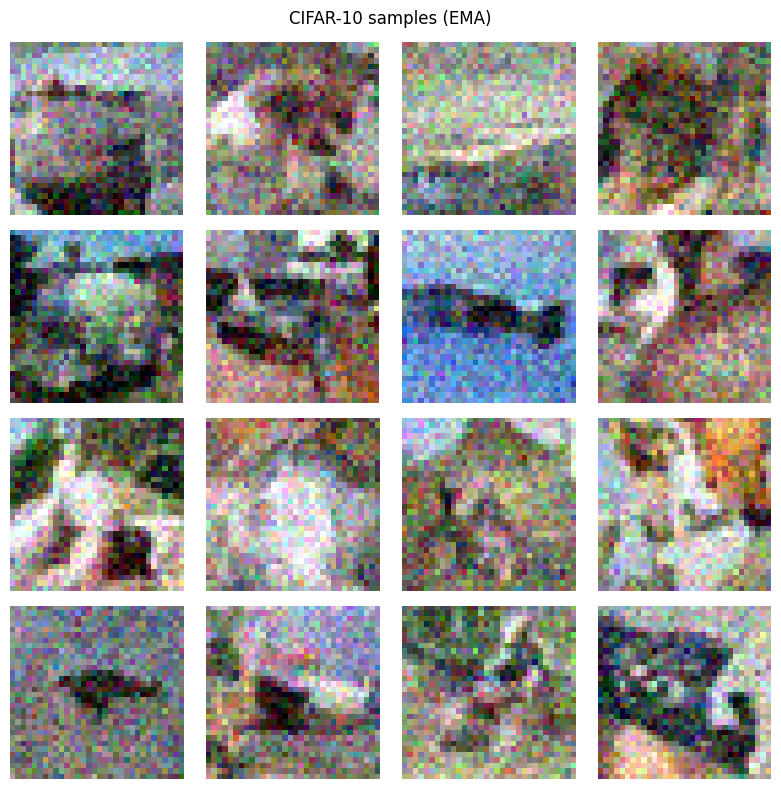

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"

samples = sample_reverse_euler_maruyama_cifar(
    ema_model, sde, num_steps=2000, batch_size=16, device=device, t_min=0.01
)
show_cifar_grid(samples, nrow=4, title="CIFAR-10 samples (EMA)")


In [17]:
state = {
    "epoch": epoch,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}
torch.save(state, "mnist_diffusion_checkpoint.pth") # Pour save le résultat du training chez vous